# IEEE-CIS fraud detection 

## 데이터 불러오기 

In [41]:
#불러오기 
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import



In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


** featuring engineering ! **

1. train/test 합쳐서 전처리 및 feature engineering 진행 필요 

2. test data 합치기 전에 target 분리 

```python
features = train_transaction.iloc[:, 2:]
target = train_transaction.iloc[:, 1]
```


In [3]:
train_identity = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/data/train_identity.csv')
test_identity = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/data/test_identity.csv')
#전처리 한 버전으로 데려와야한다
train_transaction = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/data/0615_train_pp_ver1.csv')
test_transaction = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/data/0615_test_pp_ver1.csv')

train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,M3,M4,M5,M6,M7,M8,M9,PC1,PC2,PC3
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,T,M2,F,T,NaN,NaN,NaN,-414.605554,-99.819259,100.066514
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,M0,T,T,NaN,NaN,NaN,-581.849403,-115.593458,-18.591293
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,T,M0,F,F,F,F,F,-581.849421,-115.593437,-18.591291
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,M0,T,F,NaN,NaN,NaN,2675.079606,77.806453,998.550570
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-581.849185,-115.593577,-18.591272


## modeling test

### Random forest

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import mglearn

In [ ]:
#범주형 drop 
'''
t_list = []
for i in range (len(tr_trans_pp.columns)):
    if tr_trans_pp.iloc[:,i].dtype != 'object':
        t_list.append(i)
tr_trans_pp_t = tr_trans_pp.iloc[:,t_list]      
tr_trans_pp_t.head()
'''

In [57]:
#test도 같이 처리 
total = pd.concat([train_transaction, test_transaction]) 
split_point = len(train_transaction)


In [59]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
class MultiColLabelEncoder:
    def __init__(self):
        self.encoder_dict = defaultdict(LabelEncoder)

    def fit_transform(self, X: pd.DataFrame, columns: list):  # 컬럼명 리스트 기준으로 레이블인코딩
        if not isinstance(columns, list):
            columns = [columns]

        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))

        return output

    def inverse_transform(self, X: pd.DataFrame, columns: list):  # 인코딩 된 열 레이블 복구
        if not isinstance(columns, list):
            columns = [columns]

        if not all(key in self.encoder_dict for key in columns):
            raise KeyError(f'At least one of {columns} is not encoded before')

        output = X.copy()
        try:
            output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].inverse_transform(x))
        except ValueError:
            print(f'Need assignment when do "fit_transform" function')
            raise

        return output
    
list_obj_trans = []
for i in range (len(total.iloc[0,:])) :
    if total.iloc[:, i].dtypes == 'object':
        list_obj_trans.append(total.iloc[:, i].name)
obj_to_int_trans = MultiColLabelEncoder().fit_transform(total, columns=list_obj_trans)
#obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()
df_en = obj_to_int_trans[list_obj_trans]
df_en[['TransactionID']] = total[['TransactionID']]
df_en.head()

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/1919787148.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en[['TransactionID']] = total[['TransactionID']]


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,TransactionID
0,4,1,1,60,60,1,1,1,2,0,1,2,2,2,2987000
1,4,2,1,16,60,2,2,2,0,1,1,2,2,2,2987001
2,4,3,2,35,60,1,1,1,0,0,0,0,0,0,2987002
3,4,2,2,54,60,2,2,2,0,1,0,2,2,2,2987003
4,1,2,1,16,60,2,2,2,3,2,2,2,2,2,2987004


In [78]:
list_obj_trans

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [93]:

train_tr_en = total.drop(columns = list_obj_trans, axis =1 )

train_tr_en = pd.merge(train_tr_en, df_en, on="TransactionID")
train_tr_en

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0.0,86400,68.500,13926,362.555488,150.0,142.0,315.0,87.0,...,60,1,1,1,2,0,1,2,2,2
1,2987001,0.0,86401,29.000,2755,404.000000,150.0,102.0,325.0,87.0,...,60,2,2,2,0,1,1,2,2,2
2,2987002,0.0,86469,59.000,4663,490.000000,150.0,166.0,330.0,87.0,...,60,1,1,1,0,0,0,0,0,0
3,2987003,0.0,86499,50.000,18132,567.000000,150.0,117.0,476.0,87.0,...,60,2,2,2,0,1,0,2,2,2
4,2987004,0.0,86506,50.000,4497,514.000000,150.0,102.0,420.0,87.0,...,60,2,2,2,3,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097226,4170235,NaN,34214279,94.679,13832,375.000000,185.0,224.0,284.0,60.0,...,16,2,2,2,2,2,2,2,2,2
1097227,4170236,NaN,34214287,12.173,3154,408.000000,185.0,224.0,NaN,NaN,...,19,2,2,2,2,2,2,2,2,2
1097228,4170237,NaN,34214326,49.000,16661,490.000000,150.0,226.0,327.0,87.0,...,60,1,1,1,0,0,0,0,1,1
1097229,4170238,NaN,34214337,202.000,16621,516.000000,150.0,224.0,177.0,87.0,...,60,1,1,1,0,0,0,0,0,0


In [80]:
train_tr_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097231 entries, 0 to 1097230
Data columns (total 39 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   TransactionID   1097231 non-null  int64  
 1   isFraud         590540 non-null   float64
 2   TransactionDT   1097231 non-null  int64  
 3   TransactionAmt  1097231 non-null  float64
 4   card1           1097231 non-null  int64  
 5   card2           1097231 non-null  float64
 6   card3           1092664 non-null  float64
 7   card5           1088425 non-null  float64
 8   addr1           965916 non-null   float64
 9   addr2           965916 non-null   float64
 10  dist1           453743 non-null   float64
 11  dist2           74063 non-null    float64
 12  C3              1097228 non-null  float64
 13  C5              1097228 non-null  float64
 14  C9              1097228 non-null  float64
 15  C13             1092483 non-null  float64
 16  D1              1089931 non-null  fl

In [81]:

#분리 
tr_trans_pp = train_tr_en[:split_point]
test_trans_pp = train_tr_en[split_point:]
print(tr_trans_pp.shape, test_trans_pp.shape)

(590540, 39) (506691, 39)


In [82]:
np.mean(train_tr_en.card3)

153.35556676160283

In [83]:
tr_trans_pp.card2.fillna(np.mean(tr_trans_pp.card2),inplace=True)
tr_trans_pp.card3.fillna(np.mean(tr_trans_pp.card3),inplace=True)
tr_trans_pp.card5.fillna(np.mean(tr_trans_pp.card5),inplace=True)
tr_trans_pp.addr1.fillna(-99,inplace=True)
tr_trans_pp.addr2.fillna(-99,inplace=True)

tr_trans_pp.D1.fillna(min(tr_trans_pp.D1)-1,inplace=True)
tr_trans_pp.D2.fillna( min(tr_trans_pp.D2) -1,inplace=True)
tr_trans_pp.D3.fillna(min(tr_trans_pp.D3)-1,inplace=True)
tr_trans_pp.D10.fillna(min(tr_trans_pp.D10)-1,inplace=True)
tr_trans_pp.D11.fillna(min(tr_trans_pp.D11)-1,inplace=True)
tr_trans_pp.D15.fillna(min(tr_trans_pp.D15)-1,inplace=True)

'--------------------------------------'

test_trans_pp.card2.fillna(np.mean(tr_trans_pp.card2),inplace=True)
test_trans_pp.card3.fillna(np.mean(tr_trans_pp.card3),inplace=True)
test_trans_pp.card5.fillna(np.mean(tr_trans_pp.card5),inplace=True)
test_trans_pp.addr1.fillna(-99,inplace=True)
test_trans_pp.addr2.fillna(-99,inplace=True)

test_trans_pp.D1.fillna(min(tr_trans_pp.D1)-1,inplace=True)
test_trans_pp.D2.fillna( min(tr_trans_pp.D2) -1,inplace=True)
test_trans_pp.D3.fillna(min(tr_trans_pp.D3)-1,inplace=True)
test_trans_pp.D10.fillna(min(tr_trans_pp.D10)-1,inplace=True)
test_trans_pp.D11.fillna(min(tr_trans_pp.D11)-1,inplace=True)
test_trans_pp.D15.fillna(min(tr_trans_pp.D15)-1,inplace=True)

tr_trans_pp.info()

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/999304009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_trans_pp.card2.fillna(np.mean(tr_trans_pp.card2),inplace=True)
/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/999304009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_trans_pp.card3.fillna(np.mean(tr_trans_pp.card3),inplace=True)
/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/999304009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   isFraud         590540 non-null  float64
 2   TransactionDT   590540 non-null  int64  
 3   TransactionAmt  590540 non-null  float64
 4   card1           590540 non-null  int64  
 5   card2           590540 non-null  float64
 6   card3           590540 non-null  float64
 7   card5           590540 non-null  float64
 8   addr1           590540 non-null  float64
 9   addr2           590540 non-null  float64
 10  dist1           238269 non-null  float64
 11  dist2           37627 non-null   float64
 12  C3              590540 non-null  float64
 13  C5              590540 non-null  float64
 14  C9              590540 non-null  float64
 15  C13             590540 non-null  float64
 16  D1              590540 non-null  float64
 17  D2        

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/999304009.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_trans_pp.D11.fillna(min(tr_trans_pp.D11)-1,inplace=True)
/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/999304009.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_trans_pp.D15.fillna(min(tr_trans_pp.D15)-1,inplace=True)


In [84]:
train_tr_en_col = tr_trans_pp.drop(columns = ['isFraud', 'dist1','dist2', 'D2'], axis =1 ) #D2는 왜 수정 안돼..?
test_tr_en_col = test_trans_pp.drop(columns = ['isFraud', 'dist1','dist2', 'D2'], axis =1 ) 

train_tr_en_lab = tr_trans_pp[['isFraud']]


In [85]:
#데이터: 0613 pp ver 2 사용 (tr_trans_pp)

# 데이터셋 설정
X_train, X_test, y_train, y_test = train_test_split(train_tr_en_col, train_tr_en_lab, stratify=train_tr_en_lab,test_size = 0.2, random_state=42)


In [86]:

# 모델 생성 및 학습
RFmodel = RandomForestClassifier(n_estimators=11, random_state=2).fit(X_train, y_train)
#number of estimator = tree의 개수, 모델 몇 개 쓸래?
#

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/2936651045.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFmodel = RandomForestClassifier(n_estimators=11, random_state=2).fit(X_train, y_train)


In [87]:
#평가


from sklearn.metrics import classification_report
pred = RFmodel.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113975
         1.0       0.87      0.39      0.54      4133

    accuracy                           0.98    118108
   macro avg       0.92      0.70      0.77    118108
weighted avg       0.97      0.98      0.97    118108



In [88]:
#AUC calculation
from sklearn.metrics import roc_auc_score
print("roc_auc_score:",roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))

roc_auc_score: 0.8895767783068638


/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/450029612.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


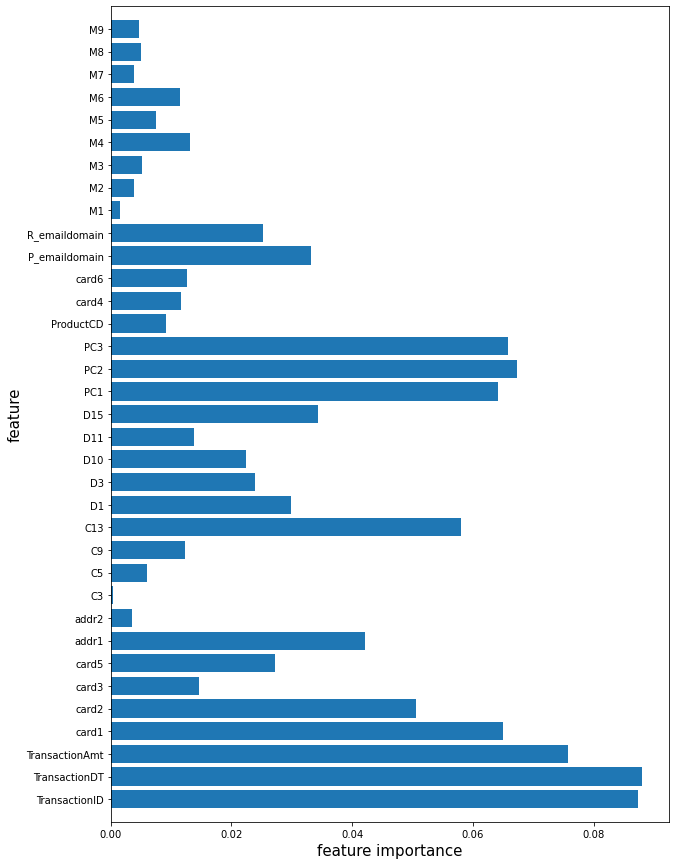

In [44]:
#feature importance
n_feature = X_train.shape[1]

index = np.arange(n_feature)

plt.figure(figsize=(10,15))

forest = RandomForestClassifier(n_estimators=11, n_jobs=-1)

forest.fit(X_train, y_train)

plt.barh(index, forest.feature_importances_, align='center')

plt.yticks(index, X_train.columns)

plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()

In [102]:
test_tr_en_col = test_tr_en_col.fillna(-1)

In [132]:
prediction = RFmodel.predict(test_tr_en_col)
prediction

array([0., 0., 0., ..., 0., 0., 0.])

In [133]:
submission = pd.read_csv("/Users/krc/PycharmProjects/1_fraud_detection/data/sample_submission.csv")
submission["isFraud"] = prediction
submission

,TransactionID,isFraud
0,3663549,0.0
1,3663550,0.0
2,3663551,0.0
3,3663552,0.0
4,3663553,0.0
...,...,...
506686,4170235,0.0
506687,4170236,0.0
506688,4170237,0.0
506689,4170238,0.0


In [134]:
#submission.to_csv('0616_RFmodel.csv', index=False) 

### XG boost ( code copied)

In [11]:
! pip install imblearn
from collections import Counter
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

In [116]:
!pip install xgboost

In [117]:
import warnings
import xgboost as xgb

print(f'xgboost=={xgb.__version__}')

from sklearn.metrics import confusion_matrix, classification_report

xgboost==1.6.1


In [118]:
def check_accuracy(y_answer, y_pred):
    accuracy = (y_answer == y_pred).sum() / y_pred.shape[0]
    return accuracy

In [8]:
#memory reduce
train_transaction = reduce_mem_usage(train_transaction)

In [ ]:
list_obj_trans = []
for i in range (len(train_transaction.iloc[0,:])) :
    if train_transaction.iloc[:, i].dtypes == 'object':
        list_obj_trans.append(train_transaction.iloc[:, i].name)
obj_to_int_trans = MultiColLabelEncoder().fit_transform(train_transaction, columns=list_obj_trans)
#obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()
df_en = obj_to_int_trans[list_obj_trans]
df_en[['TransactionID']] = train_transaction[['TransactionID']]
df_en.head()

In [ ]:
#encoding 
df_left = tr_trans_pp.drop(columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9'], axis = 1)
tr_trans_pp_en = df_left.merge(df_en, how='inner', on='TransactionID')
tr_trans_pp_en.head()

In [ ]:
#drop 없이 모델 돌려보기
#데이터: 0613 pp ver 2, encoding 해서 사용 (tr_trans_pp)

# 데이터셋 설정
tr_trans_pp_col = tr_trans_pp_en.drop(columns = 'isFraud', axis =1 )
tr_trans_pp_lab = tr_trans_pp_en[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(tr_trans_pp_col, tr_trans_pp_lab, stratify=tr_trans_pp_lab,test_size = 0.2, random_state=42)


In [ ]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 10,
    max_depth = 4,
    booster = 'gbtree',
    eta = 0.3,
    gamma = 0,    
    silent = 0,
    objective = 'binary:logistic',
    nthread = 4,
    base_score = 0.5,    
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
check_accuracy(y_pred_xgb, y_test.iloc[:,0])

### US - XGB (5배)

In [5]:
#undersampling

#Find Number of samples which are Fraud
no_frauds = len(train_transaction[train_transaction['isFraud'] == 1]) * 5 # 5배  
#Get indices of non fraud samples
non_fraud_indices = train_transaction[train_transaction.isFraud == 0].index
#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
#Find the indices of fraud samples
fraud_indices = train_transaction[train_transaction.isFraud == 1].index
#Concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices,random_indices])
#Get Balance Dataframe
under_sample = train_transaction.loc[under_sample_indices]

In [6]:
under_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123978 entries, 203 to 171302
Data columns (total 88 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   123978 non-null  float64
 1   isFraud         123978 non-null  float64
 2   TransactionDT   123978 non-null  float64
 3   TransactionAmt  123978 non-null  float64
 4   ProductCD       123978 non-null  object 
 5   card1           123978 non-null  float64
 6   card2           122027 non-null  float64
 7   card3           123669 non-null  float64
 8   card4           123667 non-null  object 
 9   card5           123062 non-null  float64
 10  card6           123669 non-null  object 
 11  addr1           105817 non-null  float64
 12  addr2           105817 non-null  float64
 13  dist1           46942 non-null   float64
 14  dist2           9720 non-null    float64
 15  P_emaildomain   104457 non-null  object 
 16  R_emaildomain   34092 non-null   object 
 17  C3      

In [113]:
df = under_sample.copy()

In [114]:
list_obj_trans = []
for i in range (len(df.iloc[0,:])) :
    if df.iloc[:, i].dtypes == 'object':
        list_obj_trans.append(df.iloc[:, i].name)
obj_to_int_trans = MultiColLabelEncoder().fit_transform(df, columns=list_obj_trans)
#obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()
df_en = obj_to_int_trans[list_obj_trans]
df_en[['TransactionID']] = df[['TransactionID']]
df_en.head()

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_3361/324271187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en[['TransactionID']] = df[['TransactionID']]


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,TransactionID
203,4,3,1,2,59,2,2,2,0,0,1,2,2,2,2987203
240,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987240
243,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987243
245,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987245
288,0,3,1,35,34,2,2,2,2,2,2,2,2,2,2987288


In [115]:
#encoding 
df_left = df.drop(columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9'], axis = 1)
tr_trans_pp_2 = df_left.merge(df_en, how='inner', on='TransactionID')
tr_trans_pp_2.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C2,C3,C4,C5,C9,C13,D2,D3,D5,D7,D8,D11,D12,D14,V311,V313,V314,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987203,1,89760,445.000,18268,583.0,150.0,226.0,251.0,87.0,NaN,NaN,2.0,0.0,0.0,0.0,2.0,4.0,57.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4,3,1,2,59,2,2,2,0,0,1,2,2,2
1,2987240,1,90193,37.098,13413,103.0,185.0,137.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,45.041664,NaN,0.0,0.0,0.0,0.0,0.0,0,3,1,19,19,2,2,2,2,2,2,2,2,2
2,2987243,1,90246,37.098,13413,103.0,185.0,137.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,45.041664,NaN,0.0,0.0,0.0,0.0,0.0,0,3,1,19,19,2,2,2,2,2,2,2,2,2
3,2987245,1,90295,37.098,13413,103.0,185.0,137.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,45.041664,NaN,0.0,0.0,0.0,0.0,0.0,0,3,1,19,19,2,2,2,2,2,2,2,2,2
4,2987288,1,90986,155.521,16578,545.0,185.0,226.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,3,1,35,34,2,2,2,2,2,2,2,2,2


In [116]:
#drop 없이 모델 돌려보기
#데이터: 0613 pp ver 2, encoding 해서 사용 (tr_trans_pp)

# 데이터셋 설정
tr_trans_pp_col = tr_trans_pp_2.drop(columns = 'isFraud', axis =1 )
tr_trans_pp_lab = tr_trans_pp_2[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(tr_trans_pp_col, tr_trans_pp_lab, stratify=tr_trans_pp_lab,test_size = 0.2, random_state=42)


In [117]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 10,
    max_depth = 4,
    booster = 'gbtree',
    eta = 0.3,
    gamma = 0,    
    silent = 0,
    objective = 'binary:logistic',
    nthread = 4,
    base_score = 0.5,    
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
check_accuracy(y_pred_xgb, y_test.iloc[:,0])

[14:25:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.8837715760606549

In [118]:

con_mat = confusion_matrix(y_pred_xgb, y_test.iloc[:,0])
print(">> confusion_matrix")
print(con_mat) #  tn, fp, fn, tp

>> confusion_matrix
[[20253  2472]
 [  410  1661]]


### US - XGB (2배)

In [ ]:
#PP import 
#tr_trans_p = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/IEEE-CIS_Fraud_Detection/0613_fraud_pp_ver2.csv')

In [107]:
#undersampling

#Find Number of samples which are Fraud
no_frauds = len(train_transaction[train_transaction['isFraud'] == 1]) * 2 #2배! 
#Get indices of non fraud samples
non_fraud_indices = train_transaction[train_transaction.isFraud == 0].index
#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
#Find the indices of fraud samples
fraud_indices = train_transaction[train_transaction.isFraud == 1].index
#Concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices,random_indices])
#Get Balance Dataframe
under_sample = train_transaction.loc[under_sample_indices]

In [108]:
train_transaction = under_sample.copy()

In [109]:
#test도 같이 처리 
total = pd.concat([train_transaction, test_transaction]) 
split_point = len(train_transaction)

In [110]:
list_obj_trans = []
for i in range (len(total.iloc[0,:])) :
    if total.iloc[:, i].dtypes == 'object':
        list_obj_trans.append(total.iloc[:, i].name)
obj_to_int_trans = MultiColLabelEncoder().fit_transform(total, columns=list_obj_trans)
#obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()
df_en = obj_to_int_trans[list_obj_trans]
df_en[['TransactionID']] = total[['TransactionID']]
df_en.head()

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_2947/2108183388.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en[['TransactionID']] = total[['TransactionID']]


,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,TransactionID
203,4,3,1,2,60,2,2,2,0,0,1,2,2,2,2987203
240,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987240
243,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987243
245,0,3,1,19,19,2,2,2,2,2,2,2,2,2,2987245
288,0,3,1,35,35,2,2,2,2,2,2,2,2,2,2987288


In [111]:

train_tr_en = total.drop(columns = list_obj_trans, axis =1 )

train_tr_en = pd.merge(train_tr_en, df_en, on="TransactionID")
train_tr_en

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987203,1.0,89760,445.000,18268,583.0,150.0,226.0,251.0,87.0,...,60,2,2,2,0,0,1,2,2,2
1,2987240,1.0,90193,37.098,13413,103.0,185.0,137.0,NaN,NaN,...,19,2,2,2,2,2,2,2,2,2
2,2987243,1.0,90246,37.098,13413,103.0,185.0,137.0,NaN,NaN,...,19,2,2,2,2,2,2,2,2,2
3,2987245,1.0,90295,37.098,13413,103.0,185.0,137.0,NaN,NaN,...,19,2,2,2,2,2,2,2,2,2
4,2987288,1.0,90986,155.521,16578,545.0,185.0,226.0,NaN,NaN,...,35,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568675,4170235,NaN,34214279,94.679,13832,375.0,185.0,224.0,284.0,60.0,...,16,2,2,2,2,2,2,2,2,2
568676,4170236,NaN,34214287,12.173,3154,408.0,185.0,224.0,NaN,NaN,...,19,2,2,2,2,2,2,2,2,2
568677,4170237,NaN,34214326,49.000,16661,490.0,150.0,226.0,327.0,87.0,...,60,1,1,1,0,0,0,0,1,1
568678,4170238,NaN,34214337,202.000,16621,516.0,150.0,224.0,177.0,87.0,...,60,1,1,1,0,0,0,0,0,0


In [112]:
train_tr_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568680 entries, 0 to 568679
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   568680 non-null  int64  
 1   isFraud         61989 non-null   float64
 2   TransactionDT   568680 non-null  int64  
 3   TransactionAmt  568680 non-null  float64
 4   card1           568680 non-null  int64  
 5   card2           558989 non-null  float64
 6   card3           565523 non-null  float64
 7   card5           563619 non-null  float64
 8   addr1           491036 non-null  float64
 9   addr2           491036 non-null  float64
 10  dist1           237248 non-null  float64
 11  dist2           42601 non-null   float64
 12  C3              568677 non-null  float64
 13  C5              568677 non-null  float64
 14  C9              568677 non-null  float64
 15  C13             563932 non-null  float64
 16  D1              562506 non-null  float64
 17  D2        

In [113]:

#분리 
tr_trans_pp = train_tr_en[:split_point]
test_trans_pp = train_tr_en[split_point:]
print(tr_trans_pp.shape, test_trans_pp.shape)

(61989, 39) (506691, 39)


In [114]:
#drop 없이 모델 돌려보기
#데이터: 0613 pp ver 2, encoding 해서 사용 (tr_trans_pp)

# 데이터셋 설정
tr_trans_en_col = tr_trans_pp.drop(columns = 'isFraud', axis =1 )
test_trans_pp.drop(columns='isFraud', inplace=True) #test set 에도 isFraud 빼주기

tr_trans_en_lab = tr_trans_pp[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(tr_trans_en_col, tr_trans_en_lab, stratify=tr_trans_en_lab,test_size = 0.2, random_state=42)


In [119]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 10,
    max_depth = 4,
    booster = 'gbtree',
    eta = 0.3,
    gamma = 0,    
    silent = 0,
    objective = 'binary:logistic',
    nthread = 4,
    base_score = 0.5,    
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("accuracy:",check_accuracy(y_pred_xgb, y_test.iloc[:,0]))

con_mat = confusion_matrix(y_pred_xgb, y_test.iloc[:,0])
print(">> confusion_matrix")
print(con_mat) #  tn, fp, fn, tp

[19:58:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


accuracy: 0.812147120503307
>> confusion_matrix
[[7529 1593]
 [ 736 2540]]


In [120]:
#AUC calculation
from sklearn.metrics import roc_auc_score
print("roc_auc_score:",roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))

roc_auc_score: 0.8558347527880081


In [128]:
prediction = xgb_clf.predict(test_trans_pp)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [129]:
submission = pd.read_csv("/Users/krc/PycharmProjects/1_fraud_detection/data/sample_submission.csv")
submission["isFraud"] = prediction
submission

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0


In [131]:
#submission.to_csv('/Users/krc/PycharmProjects/1_fraud_detection/submission/0616_XGB2_model.csv', index=False) 

### US - XGB (trans/ id merge)

In [65]:
#PP import 
#tr_trans_p = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/IEEE-CIS_Fraud_Detection/0613_fraud_pp_ver2.csv')
#tr_id = pd.read_csv('/Users/krc/PycharmProjects/1_fraud_detection/data/train_identity.csv')

In [66]:
tr_trans_p.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,M3,M4,M5,M6,M7,M8,M9,V311,V313,V314
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,T,M2,F,T,NaN,NaN,NaN,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,M0,T,T,NaN,NaN,NaN,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,T,M0,F,F,F,F,F,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,M0,T,F,NaN,NaN,NaN,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [89]:
tr_trans_pp = pd.merge(train_identity,train_transaction, how='inner',on='TransactionID')
tr_trans_pp.iloc[:,40:80].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DeviceInfo      118666 non-null  object 
 1   isFraud         144233 non-null  float64
 2   TransactionDT   144233 non-null  int64  
 3   TransactionAmt  144233 non-null  float64
 4   ProductCD       144233 non-null  object 
 5   card1           144233 non-null  int64  
 6   card2           143331 non-null  float64
 7   card3           144061 non-null  float64
 8   card4           144049 non-null  object 
 9   card5           143277 non-null  float64
 10  card6           144055 non-null  object 
 11  addr1           83786 non-null   float64
 12  addr2           83786 non-null   float64
 13  dist1           0 non-null       float64
 14  dist2           37593 non-null   float64
 15  P_emaildomain   130842 non-null  object 
 16  R_emaildomain   131083 non-null  object 
 17  C3        

In [90]:
def cut_column_50(df):
    identity_name = []
    for i in range(0, len(df.iloc[0,:]) ):
        if (df.iloc[:, i].isnull().sum() / len(df.iloc[:, 0])) < 0.5:
            identity_name.append(df.iloc[:, i].name)
    df = df[identity_name]
    return df
    print(df.info())

tr_trans_pp_1 = cut_column_50(tr_trans_pp)


tr_trans_pp_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 0 to 144232
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   144233 non-null  int64  
 1   id_01           144233 non-null  float64
 2   id_02           140872 non-null  float64
 3   id_05           136865 non-null  float64
 4   id_06           136865 non-null  float64
 5   id_09           74926 non-null   float64
 6   id_10           74926 non-null   float64
 7   id_11           140978 non-null  float64
 8   id_12           144233 non-null  object 
 9   id_13           127320 non-null  float64
 10  id_14           80044 non-null   float64
 11  id_15           140985 non-null  object 
 12  id_16           129340 non-null  object 
 13  id_17           139369 non-null  float64
 14  id_19           139318 non-null  float64
 15  id_20           139261 non-null  float64
 16  id_28           140978 non-null  object 
 17  id_29     

In [91]:
df = tr_trans_pp_1.copy()

In [92]:
list_obj_trans = []
for i in range (len(df.iloc[0,:])) :
    if df.iloc[:, i].dtypes == 'object':
        list_obj_trans.append(df.iloc[:, i].name)
obj_to_int_trans = MultiColLabelEncoder().fit_transform(df, columns=list_obj_trans)
#obj_to_int_trans[list_obj_trans].head()
# obj_to_int_trans.head()
df_en = obj_to_int_trans[list_obj_trans]
df_en[['TransactionID']] = df[['TransactionID']]
df_en.head()

/var/folders/5m/j1nv4tbn34l6v5n5hjqzx0c40000gn/T/ipykernel_4754/324271187.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en[['TransactionID']] = df[['TransactionID']]


,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,...,id_37,id_38,DeviceType,DeviceInfo,ProductCD,card4,card6,P_emaildomain,R_emaildomain,TransactionID
0,1,1,1,1,1,7,123,164,3,1,...,1,1,1,954,1,2,1,16,60,2987004
1,1,1,1,1,1,63,98,48,2,1,...,0,1,1,1727,1,3,2,1,60,2987008
2,1,0,0,0,0,75,44,260,4,0,...,1,1,0,1598,0,2,1,16,16,2987010
3,1,1,1,1,1,75,44,260,4,0,...,1,1,0,1786,0,2,2,19,19,2987011
4,1,0,0,0,0,24,44,40,3,1,...,1,1,0,723,1,3,2,2,60,2987016


In [93]:
#encoding 
df_left = df.drop(columns = ['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain'], axis = 1)
tr_trans_pp_2 = df_left.merge(df_en, how='inner', on='TransactionID')
tr_trans_pp_2.head()

,TransactionID,id_01,id_02,id_05,id_06,id_09,id_10,id_11,id_12_x,id_13,...,id_36_y,id_37_y,id_38_y,DeviceType_y,DeviceInfo_y,ProductCD,card4,card6,P_emaildomain,R_emaildomain
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,...,0,1,1,1,954,1,2,1,16,60
1,2987008,-5.0,98945.0,0.0,-5.0,NaN,NaN,100.0,NotFound,49.0,...,0,0,1,1,1727,1,3,2,1,60
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,...,0,1,1,0,1598,0,2,1,16,16
3,2987011,-5.0,221832.0,0.0,-6.0,NaN,NaN,100.0,NotFound,52.0,...,0,1,1,0,1786,0,2,2,19,19
4,2987016,0.0,7460.0,1.0,0.0,0.0,0.0,100.0,NotFound,NaN,...,0,1,1,0,723,1,3,2,2,60


In [96]:


#drop_col_list = [id_12_x, id_15_x, id_16_x, id_28_x, id_29_x, id_30_x, id_31_x, id_33_x, id_34_x, id_35_x, id_36_x, id_37_x, id_38_x, DeviceType_x, DeviceInfo_x]
# drop_col = []
# for i in drop_col_list:
#     i = str(i)
#     drop_col.append(i)
# drop_col
string = 'id_12_x, id_15_x, id_16_x, id_28_x, id_29_x, id_30_x, id_31_x, id_33_x, id_34_x, id_35_x, id_36_x, id_37_x, id_38_x, DeviceType_x, DeviceInfo_x'
 
# 한 문자씩 나누기 -> 리스트
list(string) # list() 함수 이용
string.split() # split() 함수 이용
 
 
k = string.split(', ') # 'a'를 구분자로 쪼갭니다.
print(k)

['id_12_x', 'id_15_x', 'id_16_x', 'id_28_x', 'id_29_x', 'id_30_x', 'id_31_x', 'id_33_x', 'id_34_x', 'id_35_x', 'id_36_x', 'id_37_x', 'id_38_x', 'DeviceType_x', 'DeviceInfo_x']


In [97]:
tr_trans_pp_2 = tr_trans_pp_2.drop(columns = k)

In [98]:
#drop 없이 모델 돌려보기
#데이터: 0613 pp ver 2, encoding 해서 사용 (tr_trans_pp)

# 데이터셋 설정
tr_trans_pp_col = tr_trans_pp_2.drop(columns = 'isFraud', axis =1 )
tr_trans_pp_lab = tr_trans_pp_2[['isFraud']]
X_train, X_test, y_train, y_test = train_test_split(tr_trans_pp_col, tr_trans_pp_lab, stratify=tr_trans_pp_lab,test_size = 0.2, random_state=42)


In [99]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 10,
    max_depth = 4,
    booster = 'gbtree',
    eta = 0.3,
    gamma = 0,    
    silent = 0,
    objective = 'binary:logistic',
    nthread = 4,
    base_score = 0.5,    
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print(check_accuracy(y_pred_xgb, y_test.iloc[:,0]))

con_mat = confusion_matrix(y_pred_xgb, y_test.iloc[:,0])
print(">> confusion_matrix")
print(con_mat) #  tn, fp, fn, tp

[17:20:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.9319166637778625
>> confusion_matrix
[[26472  1853]
 [  111   411]]


- XGB model 성능 향상을 위한 points


In [57]:
prediction = xgb_clf.predict(test_transaction)
prediction

ValueError: Feature shape mismatch, expected: 52, got 393

In [56]:
submission = pd.read_csv("/Users/krc/PycharmProjects/1_fraud_detection/data/sample_submission.csv")
submission

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5
...,...,...
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5


In [ ]:
submission["isFraud"] = prediction
submission